In [17]:
# Import necessary packages
import torch
import numpy as np
from dataset import Chexpert_dataset
import os
from torchvision.models import densenet121, DenseNet121_Weights
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from balancers import BinaryBalancer
from utils import calculate_bias_metrics, eo_postprocess, calc_gen_bounds, get_base_rates
from tqdm import tqdm
import seaborn as sns
sns.set_theme()

In [19]:
# Load test csv
condition = ['grouped_condition']
path_to_csv = 'csvs/test/test_' + condition[0] + '.csv'
test_df = pd.read_csv(path_to_csv)
print('Number of samples = ', len(test_df))

Number of samples =  122256


In [109]:
# Get base rates 
y = test_df[condition[0]]
a = test_df['Sex']
return_dict = True
rates,list = get_base_rates(y,a,return_dict)
rates

{'r': 0.49746433712864807,
 's': 0.34558631069231777,
 'v': 0.08963159272346552,
 'w': 0.06731775945556864}

In [110]:
np.sum(y)/len(y)

0.8430506478209658

In [108]:
np.sum(a)/len(a)

0.5862016315490992

In [21]:
# Enable GPU use
os.environ['CUDE_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")

# Get model
sex_model = densenet121(weights = DenseNet121_Weights.DEFAULT)

# Fix last layer of densenet to reflect number of classes
input_num = sex_model.classifier.in_features
sex_model.classifier = nn.Linear(input_num,1)

# Load pre-trained model
sex_model.load_state_dict(
    torch.load(os.path.join('pretrained_sex_model', "model.pt"), map_location=device)
)
sex_model = sex_model.to(device)

In [22]:
# Set in evaluation mode
sex_model.eval()

# Root dir (needs to be changed depending on if I am using remote or gaon)
root_dir_gaon = '/export/gaon1/data/bbharti1'

# Additional specifications
columns = ['Sex']
transform = transforms.Resize((320,320))
all_data = Chexpert_dataset(test_df,root_dir_gaon,columns,transform = transform)

# Evaluate model
# indices = np.arange(0,7000)
# sub_data = Subset(all_data,indices)
dataloader = DataLoader(all_data, batch_size=16, shuffle=False)
a_probs_list = []
torch.set_grad_enabled(False)
for i, data in enumerate(tqdm(dataloader)):
    image, label, image_paths = data
    image = image.to(device)
    label = label.to(device)
    output = sex_model(image)
    output = torch.sigmoid(output)
    a_probs_list.append(output)
a_probs = torch.cat(a_probs_list).cpu().ravel()
a_hat = (a_probs >=0.5)
a_hat = a_hat.cpu().numpy().astype('float')
U = np.sum(a_hat != test_df.Sex.values)/len(a_hat)
print('a_hat error = ', U)

100%|██████████| 7641/7641 [07:47<00:00, 16.35it/s]


a_hat error =  0.02290276141866248


In [23]:
# Evaluate classifier on f
model = densenet121(weights = DenseNet121_Weights.DEFAULT)

# Fix last layer of densenet to reflect number of classes
input_num = model.classifier.in_features
model.classifier = nn.Linear(input_num,1)

# Load pre-trained model
model.load_state_dict(
    torch.load(os.path.join('pretrained_classifier', condition[0] + '_model.pt'), map_location=device)
)
model = model.to(device)

In [24]:
# Create test set
columns = condition
test_set = Chexpert_dataset(test_df,root_dir_gaon,columns,transform=transform)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)
y_probs_list = []
torch.set_grad_enabled(False)
for i, data in enumerate(tqdm(test_loader)):
    image, label, image_paths = data
    image = image.to(device)
    label = label.to(device)
    output = model(image)
    output = torch.sigmoid(output)
    y_probs_list.append(output)
y_probs = torch.cat(y_probs_list).cpu().ravel()
y_probs = y_probs.detach().numpy()
y = test_df[condition].values.ravel()

100%|██████████| 7641/7641 [08:24<00:00, 15.14it/s]


In [43]:
# Add a_hat and y_prob columns to dataframe
test_df['a_hat'] = a_hat
test_df['y_prob'] = y_probs
test_df.head()
test_df.to_csv('csvs/results/results_' + condition[0] + '.csv')

In [144]:
# Load data
test_df = pd.read_csv('csvs/results/results_Pleural Effusion.csv',index_col=[0])
test_df.head()

,Patient_ID_path,Path,Sex,Pleural Effusion,group,a_hat,y_prob
0,CheXpert-v1.0-small/train/patient58318,CheXpert-v1.0-small/train/patient58318/study1/...,0,0.0,4.0,0.0,0.123156
1,CheXpert-v1.0-small/train/patient22729,CheXpert-v1.0-small/train/patient22729/study1/...,1,0.0,3.0,1.0,0.086232
2,CheXpert-v1.0-small/train/patient13488,CheXpert-v1.0-small/train/patient13488/study1/...,1,0.0,3.0,1.0,0.066037
3,CheXpert-v1.0-small/train/patient05056,CheXpert-v1.0-small/train/patient05056/study15...,1,0.0,3.0,1.0,0.310323
4,CheXpert-v1.0-small/train/patient00480,CheXpert-v1.0-small/train/patient00480/study12...,1,0.0,3.0,1.0,0.030275


In [145]:
# Split data into final test and val/tune data
df, val_df = train_test_split(test_df,test_size=0.25,stratify=test_df['group'],random_state=10)

In [146]:
# Plot ROC curve and identify best threshold for J-statistic
y = val_df['Pleural Effusion'].values
y_prob = val_df.y_prob.values
tpr = []
fpr = []
thresholds = np.linspace(0,1,101)
for t in thresholds:
    y_hat = (y_prob >= t)
    tn, fp, fn, tp = confusion_matrix(y,y_hat).ravel()
    tpr.append(tp/(tp + fn))
    fpr.append(fp/(fp + tn))

Best t =  0.46


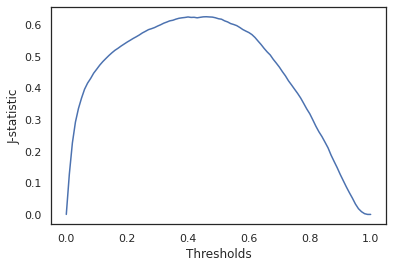

In [147]:
# Plot ROC
tpr = np.array(tpr)
fpr = np.array(fpr)
plt.plot(thresholds,tpr-fpr)
plt.xlabel('Thresholds')
plt.ylabel('J-statistic')
max_index = np.argmax(tpr-fpr)
opt_t = thresholds[max_index]
print('Best t = ', opt_t)

In [149]:
# Learn a fair model using val_df
# Rename columns
val_df = val_df.rename(columns={"Sex": "a", 'Pleural Effusion': "y"})

# Make unfair predictions
y = val_df.y.values
a = val_df.a.values
y_prob = val_df.y_prob.values.copy()
ind_1 = np.where(a==1)
ind_0 = np.where(a==0)
y_prob[ind_1] = (y_prob[ind_1] >= opt_t)
y_prob[ind_0] = (y_prob[ind_0] >= 0.2)
val_df['y_hat'] = y_prob

# Learn fair model wrt to a_hat
val_df['a'] = val_df['a_hat']
val_df['y_prob'] = val_df['y_hat']
_, fair_model = eo_postprocess(val_df)

In [150]:
# Rename columns
df = df.rename(columns={"Sex": "a", 'Pleural Effusion': "y"})

# Make unfair predictions
y = df.y.values
a = df.a.values
y_prob = df.y_prob.values.copy()
ind_1 = np.where(a==1)
ind_0 = np.where(a==0)
y_prob[ind_1] = (y_prob[ind_1] >= opt_t)
y_prob[ind_0] = (y_prob[ind_0] >= 0.2)
df['y_hat'] = y_prob
# df['y_hat'] = (df.y_prob.values >= opt_t).astype('float')
df.head()

,Patient_ID_path,Path,a,y,group,a_hat,y_prob,y_hat
4787,CheXpert-v1.0-small/train/patient24163,CheXpert-v1.0-small/train/patient24163/study69...,0,0.0,4.0,0.0,0.603124,1.0
49381,CheXpert-v1.0-small/train/patient20150,CheXpert-v1.0-small/train/patient20150/study1/...,1,0.0,3.0,1.0,0.005918,0.0
96145,CheXpert-v1.0-small/train/patient21414,CheXpert-v1.0-small/train/patient21414/study2/...,1,0.0,3.0,1.0,0.050979,0.0
31155,CheXpert-v1.0-small/train/patient28814,CheXpert-v1.0-small/train/patient28814/study1/...,0,0.0,4.0,0.0,0.386185,1.0
93339,CheXpert-v1.0-small/train/patient25905,CheXpert-v1.0-small/train/patient25905/study5/...,0,0.0,4.0,0.0,0.322366,1.0


In [151]:
B = 10
error = []
bias_tpr = []
upper_bound = []
lower_bound = []
post_bias_tpr = []
post_upper_bound = []
post_lower_bound = []
fair_model = fair_model
for i in tqdm(range(B)):
    # Bootstrapping
    df_sample = df.sample(n=len(df),replace=True)

    # Calculate true bias_tpr
    alpha,beta,tau,phi = calculate_bias_metrics(df_sample)
    bias_tpr.append(alpha-beta)

    # Calculate upper and lower bounds 
    df_a_hat = df_sample.copy(deep=True)
    # Calculate bootstrapped base rates and error U 
    y = df_a_hat.y.values
    a = df_a_hat.a.values
    rates  = get_base_rates(y,a,return_dict=False)
    r = rates['r']
    s = rates['s']
    U = np.sum(df_a_hat.a.values != df_a_hat.a_hat.values)/len(df_a_hat)
    error.append(U)
    # U = 0.01
    # Let a_hat "be" a
    df_a_hat['a'] = df_a_hat['a_hat']
    df_a_hat['y_prob'] = df['y_hat']
    alpha_hat,beta_hat,tau_hat,phi_hat = calculate_bias_metrics(df_a_hat)
    ub, lb = calc_gen_bounds(alpha_hat,beta_hat,U,r,s)
    upper_bound.append(ub)
    lower_bound.append(lb)
    
    # Post process
    # _, fair_model = eo_postprocess(df_a_hat)
    y_fair = fair_model.predict(df_a_hat.y_hat.values,df_a_hat.a.values)
    df_fair = df_a_hat.copy(deep=True)
    df_fair['y_hat'] = y_fair

    # Calculate post bias_tpr
    alpha,beta,tau,phi = calculate_bias_metrics(df_fair)
    post_bias_tpr.append(alpha-beta)
    ub, lb = calc_gen_bounds(alpha,beta,U,r,s)
    post_upper_bound.append(ub)
    post_lower_bound.append(lb)

100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


In [152]:
rates

{'r': 0.2336081664703573,
 's': 0.16865157265628408,
 'v': 0.3501723160144833,
 'w': 0.24756794485887537}

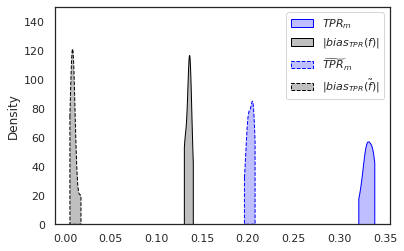

In [154]:
max_bound_pre = np.maximum(np.abs(upper_bound),np.abs(lower_bound))
max_bound_post = np.maximum(np.abs(post_upper_bound),np.abs(post_lower_bound))
sns.kdeplot(max_bound_pre,shade=True,cut=0,label = '$TPR_{m}$',color='blue')
sns.kdeplot(np.abs(bias_tpr),shade=True,cut=0,label = r'$|bias_{TPR}(f)|$', color = 'black')
sns.kdeplot(max_bound_post,shade=True,cut=0,label = r'$\widetilde{TPR}_{m}$', color = 'blue',linestyle = '--')
sns.kdeplot(np.abs(post_bias_tpr),shade=True,cut=0,label = r'$|bias_{TPR}(\tilde{f})|$',color='black', linestyle = '--')
plt.ylim([0,150])
plt.legend()